# Second empirical example for optimization of enzyme reaction rates

### Popular choices to model the reaction rate in dependency of T
#### 1. Ratkowksy model up to $T_{opt}$ and Gaussian model from there

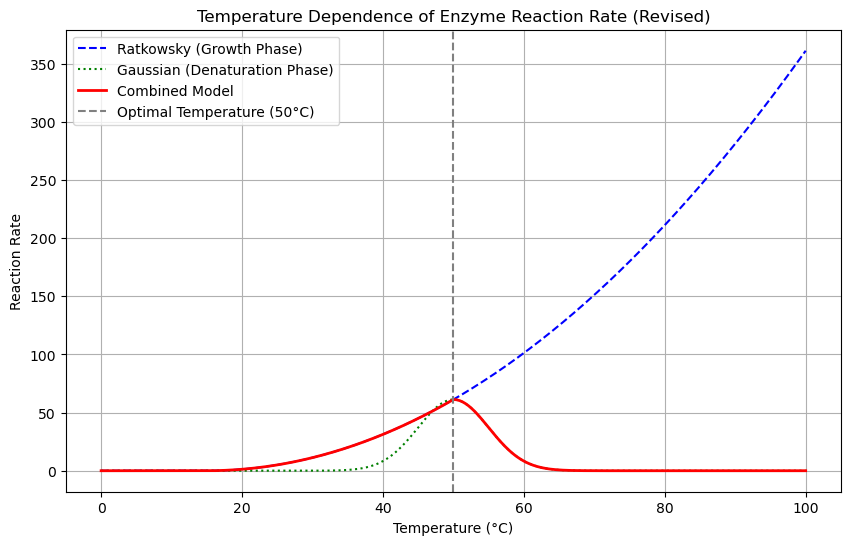

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Temperature range
T = np.linspace(0, 100, 500)  # Temperature range (0-100°C)

# Ratkowsky equation parameters
T_min = 15   # Minimum temperature for activity
b = 0.05    # Growth constant

# Gaussian model parameters
T_opt = 50  # Optimal temperature
sigma = 5  # Spread of the Gaussian

# Compute the Ratkowsky curve (valid for T > T_min)
ratkowsky_curve = np.where(T > T_min, b * (T - T_min)**2, 0)

# Determine the Gaussian scale at the transition point
r_opt = b * (T_opt - T_min)**2  # Value of Ratkowsky curve at T_opt

# Compute the Gaussian curve (scaled to match Ratkowsky at T_opt)
gaussian_curve = r_opt * np.exp(-(T - T_opt)**2 / (2 * sigma**2))

# Combine the two for an empirical bell-shaped curve
combined_curve = np.where(T < T_opt, ratkowsky_curve, gaussian_curve)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(T, ratkowsky_curve, label="Ratkowsky (Growth Phase)", linestyle="--", color="blue")
plt.plot(T, gaussian_curve, label="Gaussian (Denaturation Phase)", linestyle=":", color="green")
plt.plot(T, combined_curve, label="Combined Model", linewidth=2, color="red")
plt.axvline(T_opt, color="gray", linestyle="--", label=f"Optimal Temperature ({T_opt}°C)")

plt.title("Temperature Dependence of Enzyme Reaction Rate (Revised)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Reaction Rate")
plt.legend()
plt.grid()
plt.show()

#### 2. Alternative: Extended Ratkowsky model

$k = b * \left(T - T_\mathrm{min}\right)^2 \cdot \left(1 - e^{c \cdot (T - T_\mathrm{max})}\right),$ 

$k=0$ for $T>T_\mathrm{max}$ or $T<T_\mathrm{min}$


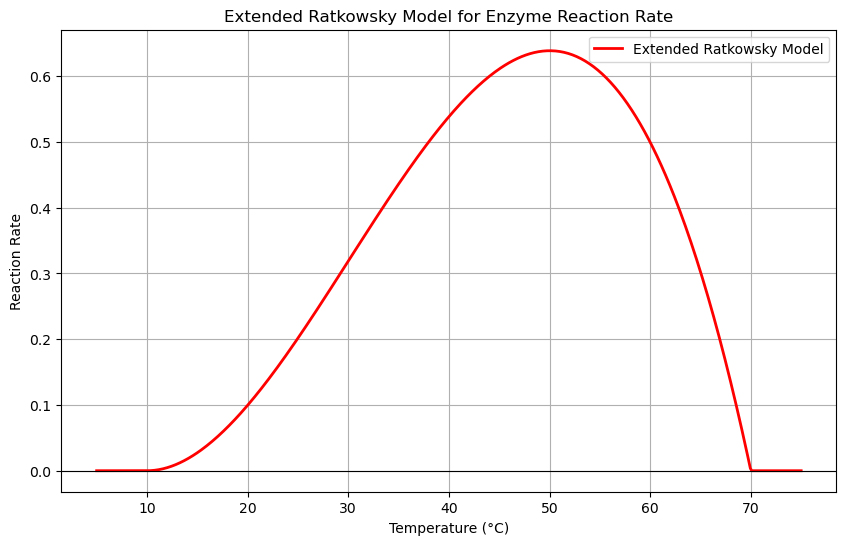

In [2]:
import matplotlib.pyplot as plt

from kinetics import ratkowsky_curve

# Plotting the Ratkowsky curve over a temperature range
T_min = 10    # Minimum temperature for activity
T_max = 70   # Maximum temperature (activity zero greater or equal to this)
T = np.linspace(T_min-5, T_max+5, 500)  # Temperature range between 5 and T_max
b = 0.1   # Growth constant
c = 0.0002    # Decay constant

extended_ratkowsky_curve = ratkowsky_curve(T, T_min=T_min, T_max=T_max, b=b, c=c)

plt.figure(figsize=(10, 6))
plt.plot(T, extended_ratkowsky_curve, label="Extended Ratkowsky Model", color="red", linewidth=2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Extended Ratkowsky Model for Enzyme Reaction Rate")
plt.xlabel("Temperature (°C)")
plt.ylabel("Reaction Rate")
plt.legend()
plt.grid()
plt.show()


## Case study: Optimization of reaction rates

The enzymes follows a first-order kinetic model. The reaction rate is dependent on the temperature according to the extended Ratkowksy model, which is however unknown beforehand.

### Step 1: Generate mock data.
Generate data from two batch experiments, each having three measurements (e.g. shake flaks in incubators at different temperatures). Let's first not assume batch effects.

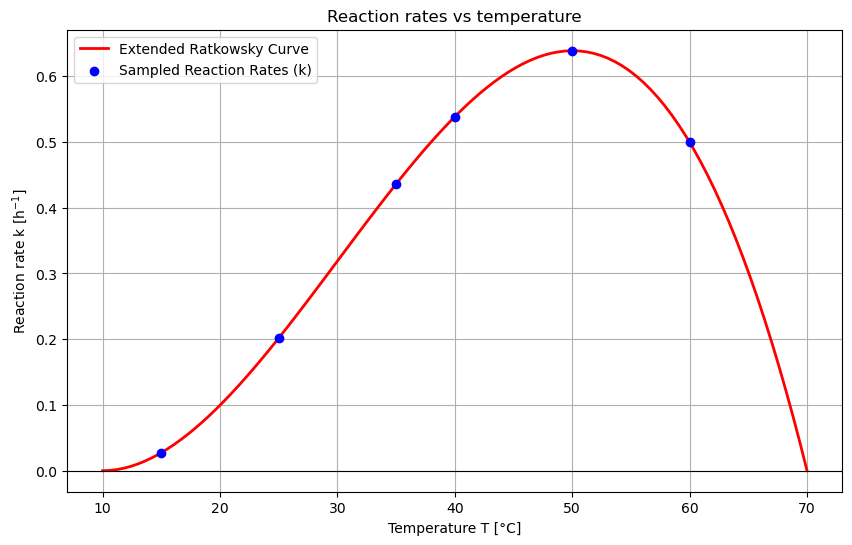

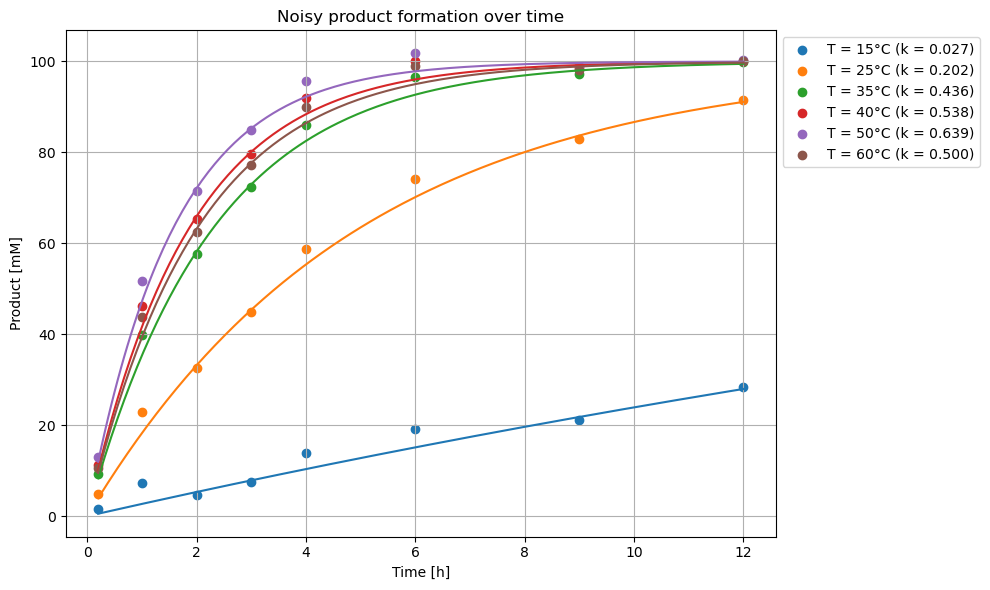

In [3]:
from utils import extract_high_res_P_series, get_P_samples


# Fixed sampled temperatures (°C)
T_sampled = np.array([15, 25, 35, 40, 50, 60])

# Compute reaction rates (k) for sampled temperatures
reaction_rates = ratkowsky_curve(T_sampled, T_min=T_min, T_max=T_max, b=b, c=c)

# Generate the full dependency curve of k on T for plotting
T_full = np.linspace(T_min, T_max, 100)  # Fine-grained temperature range for the curve
k_full = ratkowsky_curve(T_full, T_min=T_min, T_max=T_max, b=b, c=c)

# Time sampling
time = np.array([0.2, 1, 2, 3, 4, 6, 9, 12])

# Initial substrate concentration (mM)
S0 = 100

# Compute product formation (P) over time for each temperature and reaction rate
P_samples = {}
for i, rate in enumerate(reaction_rates):
    P_noisy = get_P_samples(
        k=rate,
        S0=100,
        time=time,
        seed=20241125+1, # set a seed
    )
    P_samples[rate] = P_noisy


# Plot Reaction Rate vs Temperature with Dependency Curve
plt.figure(figsize=(10, 6))
plt.plot(T_full, k_full, color="red", label="Extended Ratkowsky Curve", linewidth=2)
plt.scatter(T_sampled, reaction_rates, color="blue", label="Sampled Reaction Rates (k)", zorder=3)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Reaction rates vs temperature")
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.legend()
plt.grid()
plt.show()

# Plot Product Formation Over Time
plt.figure(figsize=(10, 6))

# Plot noisy product formation curves
for i, k in enumerate(P_samples.keys()):
    P_noisy = P_samples[k]
    plt.scatter(time, P_noisy, marker="o", label=f"T = {T_sampled[i]}°C (k = {reaction_rates[i]:.3f})")
    plt.plot(*(extract_high_res_P_series(time, k)))

plt.title("Noisy product formation over time")
plt.xlabel("Time [h]")
plt.ylabel("Product [mM]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()


### Step 2: Prepare the data as a numpy array with shape (catalyst, time points)

In [4]:
observed = []
for tseries in P_samples.values():
    observed.append(list(tseries))
observed = np.array(observed)
print(observed.shape)

(6, 8)


### Step 3: Build the PyMC model

In [5]:
import pymc as pm
import pytensor.tensor as pt

coords = {
    "catalyst": np.arange(6),
    "time": time,
}

with pm.Model(coords=coords) as pmodel:
    # k = pm.HalfNormal("k", dims="catalyst")
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    S_0 = pm.Normal("S0", mu=100, sigma=5)
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_t", X=T_sampled[:, None], jitter=1e-4)
    P = pm.Deterministic("P", S_0 * (1 - pt.exp(-k[:, None] * time[None, :])), dims=("catalyst", "time"))
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed,
        dims=("catalyst", "time")
    )
    trace = pm.sample(5000, tune=1000, chains=8, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, k_over_t_rotated_]


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 18 seconds.


### Step 4: Analyze the model

#### Trace plot

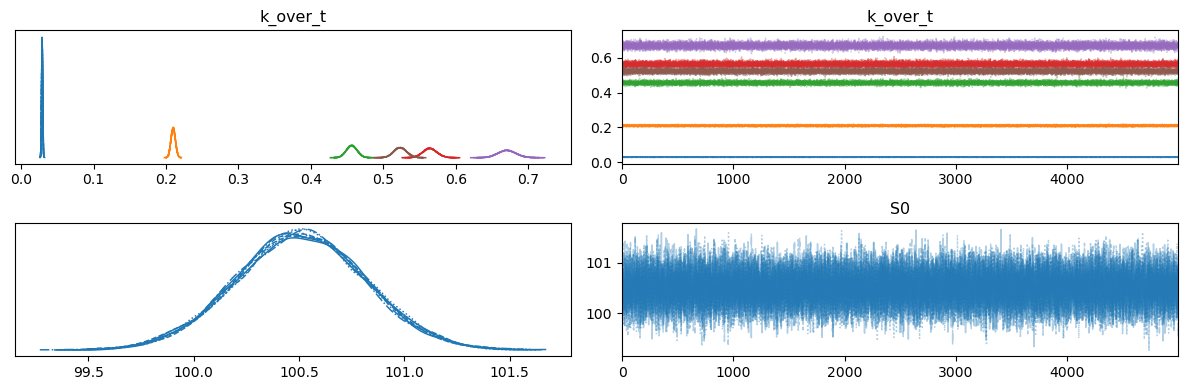

In [6]:
from matplotlib import pyplot as plt
pm.plot_trace(trace, var_names=["k_over_t", "S0"])
plt.tight_layout()

#### Posterior for GP

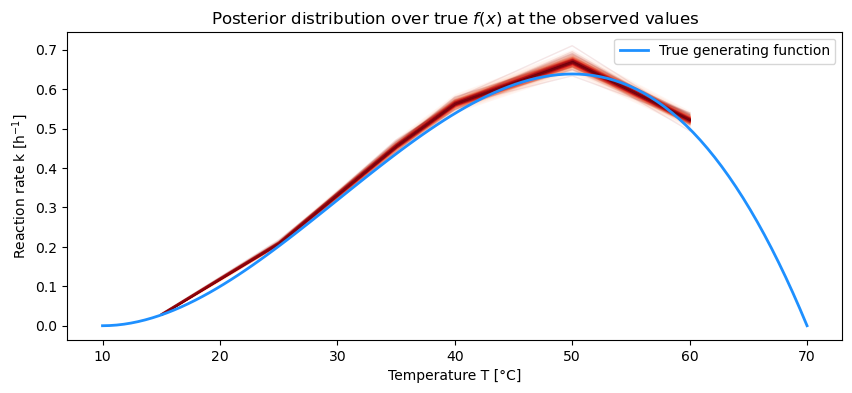

In [7]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist
import arviz as az

f_post = az.extract(trace, var_names="k_over_t").transpose("sample", ...)
plot_gp_dist(ax, f_post, T_sampled[:, None])


# plot the data and the true latent function
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

#### Compute posterior predictive, which can also be used for further Bayesian optimization

In [8]:
with pmodel:
    # add the GP conditional to the model, given the new X values
    f_pred = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace.extend(pm.sample_posterior_predictive(trace, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

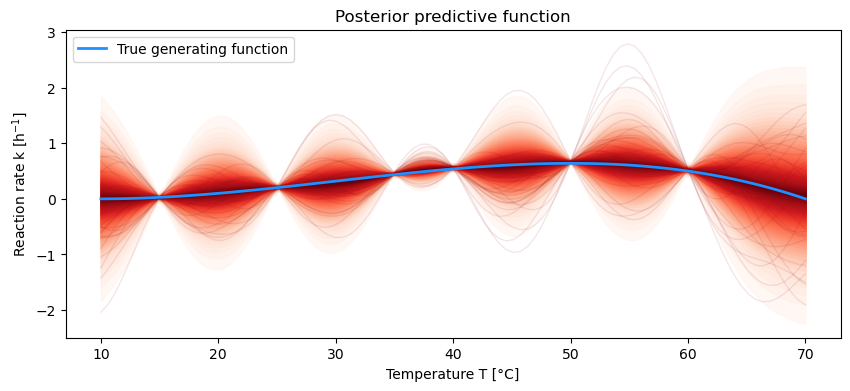

In [9]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred = az.extract(trace.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();

## Case study 2: Base case plus fitting the length scale

In [10]:
coords = {
    "catalyst": np.arange(6),
    "time": time,
}

with pm.Model(coords=coords) as pmodel2:
    # k = pm.HalfNormal("k", dims="catalyst")
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    S_0 = pm.Normal("S0", mu=100, sigma=5)
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )
    ell = pm.Gamma("ell", alpha=2, beta=1)
    cov_func = pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_t", X=temp_data[:, None], jitter=1e-4)
    P = pm.Deterministic("P", S_0 * (1 - pt.exp(-k[:, None] * timepoints[None, :])), dims=("catalyst", "time"))
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed,
        dims=("catalyst", "time")
    )

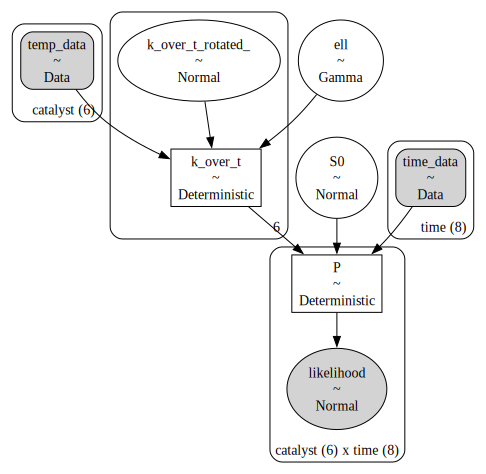

In [11]:
pmodel2.to_graphviz()

Sampling: [ell]


array([[<Axes: title={'center': 'ell'}>, <Axes: title={'center': 'ell'}>]],
      dtype=object)

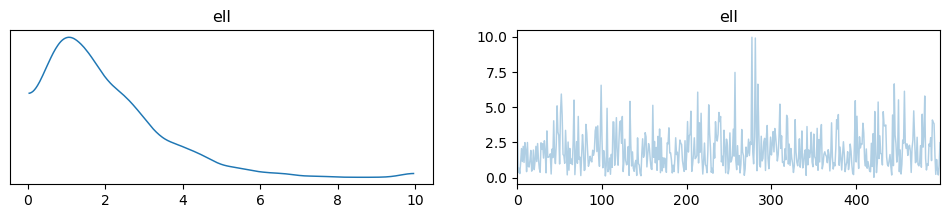

In [12]:
pp = pm.sample_prior_predictive(model=pmodel2, var_names=["ell"])
az.plot_trace(pp.prior)

In [13]:
with pmodel2:
    trace2 = pm.sample(5000, tune=1000, chains=8, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, ell, k_over_t_rotated_]


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 171 seconds.
There were 2646 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Analytical plots

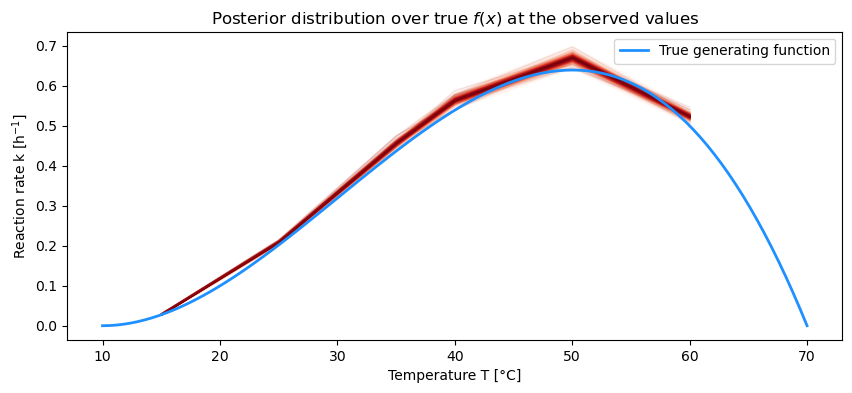

In [14]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
f_post2 = az.extract(trace2, var_names="k_over_t").transpose("sample", ...)
plot_gp_dist(ax, f_post2, T_sampled[:, None])


# plot the data and the true latent function
# ax.plot(, f_true, "dodgerblue", lw=3, label="True generating function "f"")
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

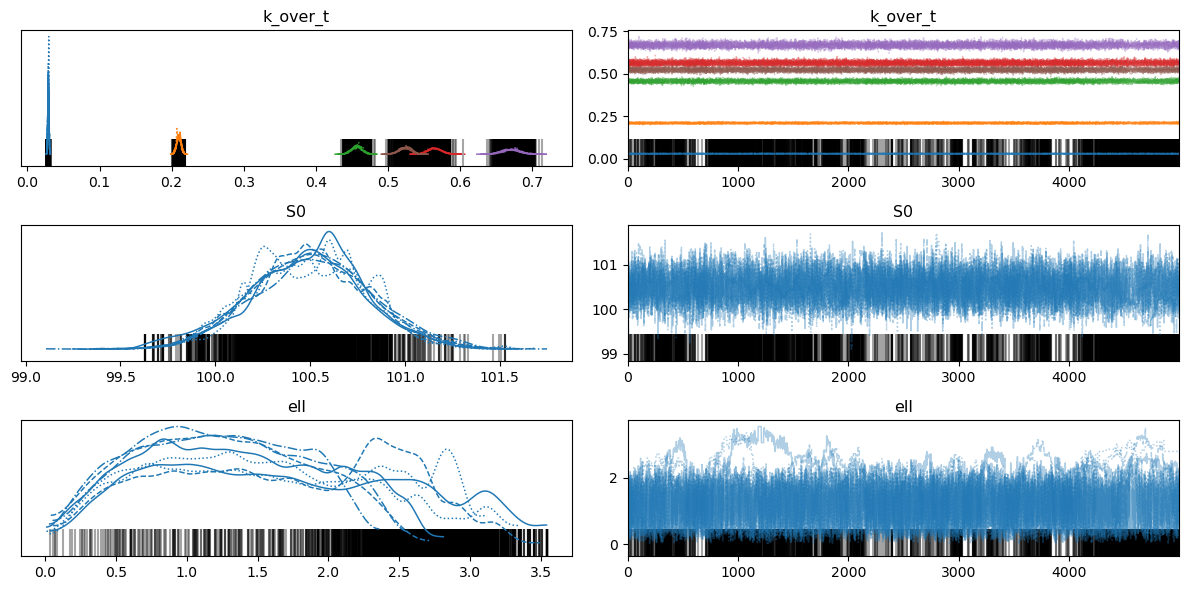

In [15]:
pm.plot_trace(trace2, var_names=["k_over_t", "S0", "ell"])
plt.tight_layout()

In [16]:
with pmodel2:
    # add the GP conditional to the model, given the new X values
    f_pred2 = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace2.extend(pm.sample_posterior_predictive(trace2, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

### Posterior predictive

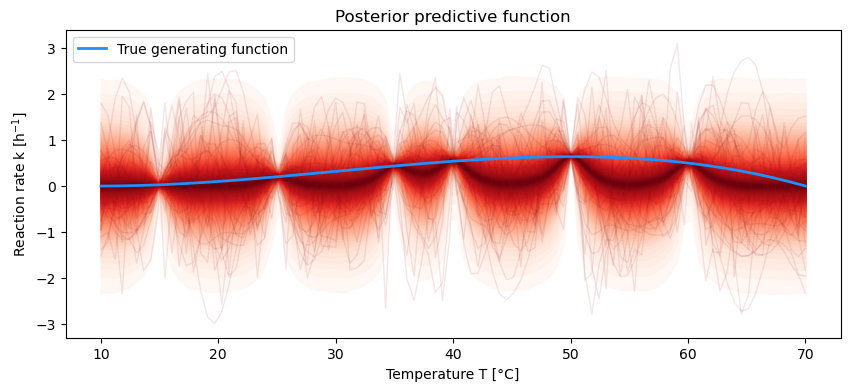

In [17]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred2 = az.extract(trace2.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred2, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();

#### Comparison of PP for both models

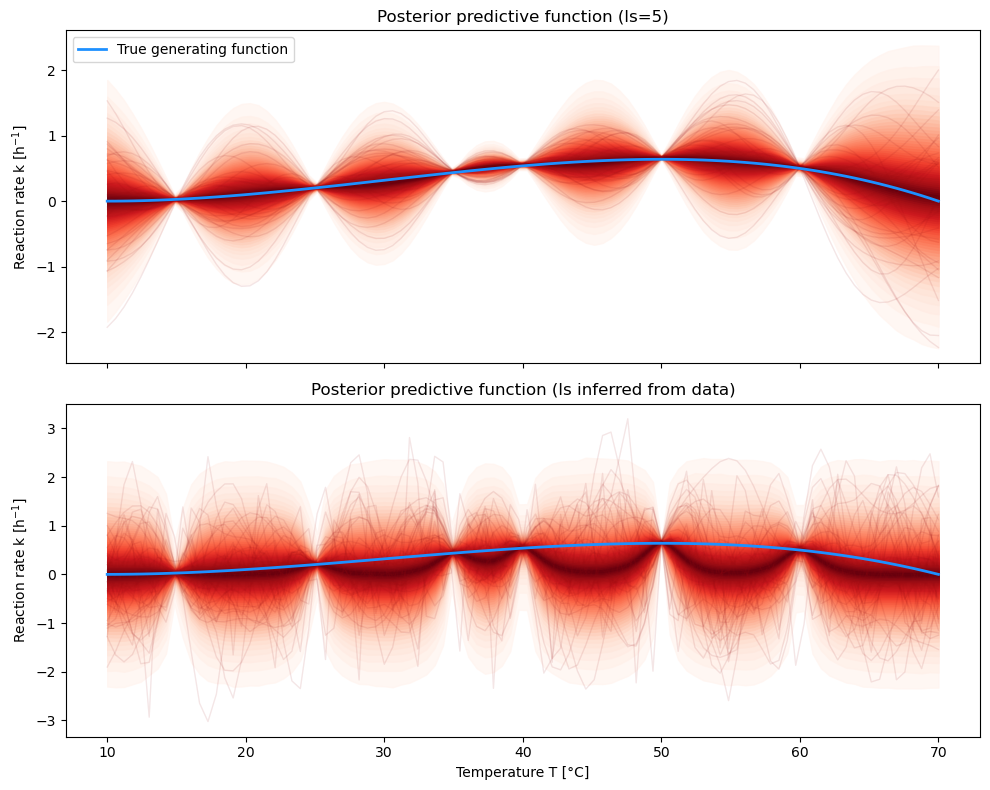

In [18]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)

ax = axs[0]
f_pred = az.extract(trace.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (ls=5)")
ax.legend()

ax = axs[1]
f_pred2 = az.extract(trace2.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred2, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (ls inferred from data)")
plt.tight_layout()
plt.show()

In [19]:
# TODO: Batch-Effekte (z.B. neuer Mastermix), Batch-Größe 3, Zeit-Delay oder ein Schüttler mit Offset -> Kolben oder andere Gefäße

## Introduction of Batch effect
### Step 1: Generate more complex data

In [20]:
import pandas as pd
shakers = [1, 2, 3, 1, 4, 2, 3, 4]
batches = [1, 1, 1, 2, 1, 2, 2, 2]
df = pd.DataFrame([], columns=["time", "batch", "device", "P_noisy", "S0", "k_true", "T_true"])
index = 0
T_sampled = np.array([15, 25, 30, 30, 35, 45, 55, 68])
S0_true = [109, 97]
true_rates = []
for i, T_value in enumerate(T_sampled):
    batch = batches[i]
    S0 = S0_true[batch-1]
    k_value = ratkowsky_curve(
        T=T_value,
        T_min=T_min,
        T_max=T_max,
    )
    P_samples = get_P_samples(
        k=float(k_value),
        S0=S0,
        time=time,
        sigma=7,
        seed=2024121 + i, # set seed
    )
    true_rates.append(k_value)
    for j, P_value in enumerate(P_samples):
        index += 1
        # P_offset = P_value + offsets[shakers[i]-1]
        df.loc[index] = [
            time[j],
            batch,
            shakers[i],
            P_value,
            # P_offset,
            S0,
            k_value,
            T_value
        ]
df.set_index(["device", "batch"], inplace=True)
df



time    P_noisy   S0               k_true  T_true
device batch                                                   
1      1       0.2   5.922414  109  0.02734930306157818      15
       1       1.0   0.000000  109  0.02734930306157818      15
       1       2.0   6.310213  109  0.02734930306157818      15
       1       3.0  10.389730  109  0.02734930306157818      15
       1       4.0  18.384931  109  0.02734930306157818      15
...            ...        ...  ...                  ...     ...
4      2       3.0  30.813144   97   0.1345330915879003      68
       2       4.0  53.344851   97   0.1345330915879003      68
       2       6.0  64.682251   97   0.1345330915879003      68
       2       9.0  75.470721   97   0.1345330915879003      68
       2      12.0  81.654965   97   0.1345330915879003      68

[64 rows x 5 columns]

### Formay data as array

In [21]:
print(time.shape)
observed_bias = df.P_noisy.values.reshape((8, time.shape[0]))
print(observed_bias)

(8,)
[[  5.92241418   0.           6.31021269  10.38973017  18.38493058
   12.69413931  17.24532395  29.98885042]
 [  3.8706728   20.34320532  40.89154039  38.37629045  63.95347847
   80.28962243  90.26211294  96.40947938]
 [  0.          41.55608364  57.32911508  80.98694948  81.34337462
   80.67486892  98.4457822  114.7183389 ]
 [  0.          23.50759259  52.03951647  64.37011979  72.54735421
   74.03049579 105.53384678 102.15196113]
 [  8.35251476  44.0031286   67.74537984  73.35743621  88.29813412
   99.54372808 110.99006309 106.67042029]
 [  6.30073611  43.67750627  73.86490851  77.39782681  85.02569214
   94.27101651  94.20327564  93.80605498]
 [ 12.4684604   50.19445048  69.39869206  79.16747074  87.70461855
   93.44888105  98.8824251   98.23874767]
 [  0.           9.15434067  27.33835524  30.81314356  53.34485103
   64.68225069  75.47072111  81.65496466]]


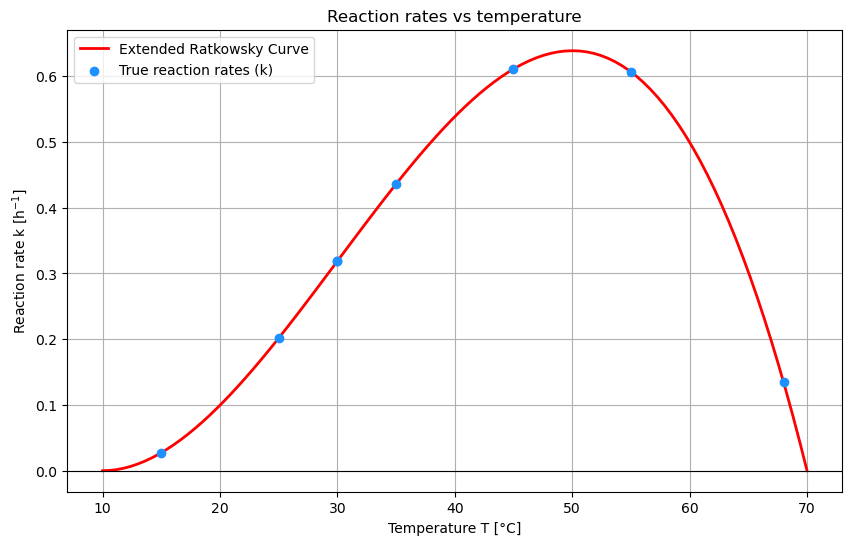

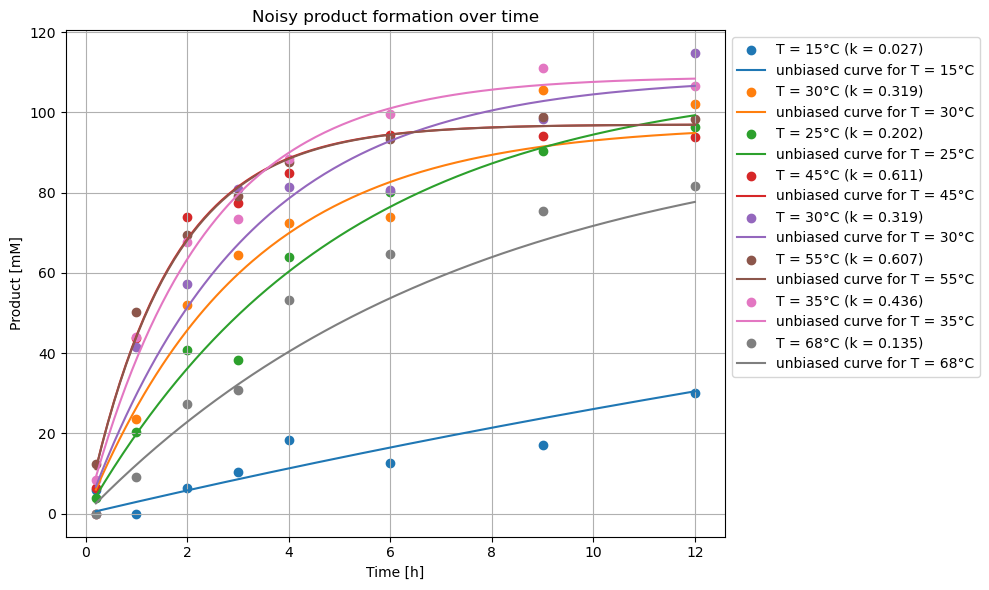

In [22]:
# Plot Reaction Rate vs Temperature with Dependency Curve
plt.figure(figsize=(10, 6))
plt.plot(T_full, k_full, color="red", label="Extended Ratkowsky Curve", linewidth=2)
plt.scatter(T_sampled, true_rates, color="dodgerblue", label="True reaction rates (k)", zorder=3)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Reaction rates vs temperature")
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.legend()
plt.grid()
plt.show()

# Plot Product Formation Over Time
plt.figure(figsize=(10, 6))

# Plot noisy product formation curves
for (shaker, batch), data in df.groupby(["device", "batch"]):
    S0 = data.S0.values[0]
    t_data = data.time.values
    P_data = data.P_noisy.values
    k_value = data.k_true.values[0]
    temp = data.T_true.values[0]
    
    plt.scatter(t_data, P_data, marker="o", label=f"T = {temp}°C (k = {k_value:.3f})")
    plt.plot(*(extract_high_res_P_series(
        time=t_data,
        k=k_value,
        S0=S0,
    )), label=f"unbiased curve for T = {temp}°C")

plt.title("Noisy product formation over time")
plt.xlabel("Time [h]")
plt.ylabel("Product [mM]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

### Step 2: Build PyMC model with batch effect for substrate

In [23]:
coords = {
    "catalyst": np.arange(8),
    "time": time,
    "batch": [1, 2],
    "shaker": [1, 2, 3],
}

with pm.Model(coords=coords) as pmodel3:
    # k = pm.HalfNormal("k", dims="catalyst")
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    S_0 = pm.Normal("S0", mu=100, sigma=0.5)
    S_batch = pm.Normal("S_batch", mu=0, sigma=2, dims="batch")
    S_catalyst = pm.Deterministic(
        "S_catalyst",
        pt.stack([
            S_0 + S_batch[0],
            S_0 + S_batch[0],
            S_0 + S_batch[0],
            S_0 + S_batch[1],
            S_0 + S_batch[0],
            S_0 + S_batch[1],
            S_0 + S_batch[1],
            S_0 + S_batch[1],
            ]),
        dims="catalyst"
    )
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_T", X=temp_data[:, None], jitter=1e-4, dims="catalyst")
    # P_offsets = pm.Uniform("P_offset", lower=-5, upper=5, dims="shaker")
    
    P = pm.Deterministic("P", S_catalyst[:, None] * (1 - pt.exp(-k[:, None] * timepoints[None, :])), dims=("catalyst", "time"))
    # # the order of shakers is hard-coded here, but should ideally be read from the data
    # P_shaker_offset = pm.Deterministic(
    #     "P_shaker_offset",
    #     pt.stack([
    #         P[0, :] + P_offsets[1, None],
    #         P[1, :] + P_offsets[0, None],
    #         P[2, :] + P_offsets[2, None],
    #         P[3, :] + P_offsets[0, None],
    #         P[4, :] + P_offsets[1, None],
    #         P[5, :] + P_offsets[2, None],
    #     ]),
    #     dims=("catalyst", "time")
    # )
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed_bias,
        dims=("catalyst", "time")
    )


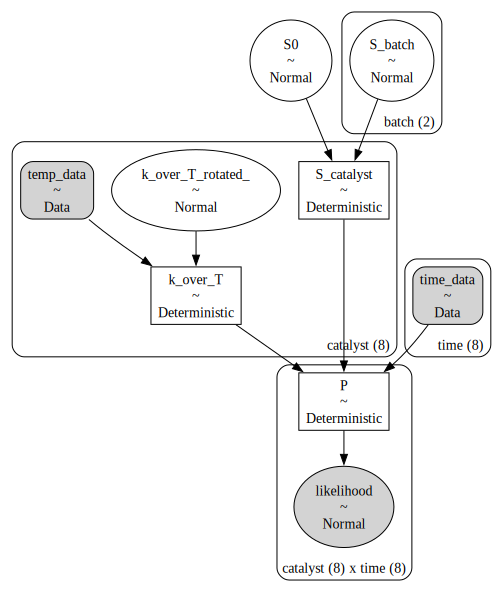

In [24]:
pmodel3.to_graphviz()

In [25]:
with pmodel3:
    trace3 = pm.sample(5000, tune=1000, chains=8, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, S_batch, k_over_T_rotated_]


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 58 seconds.


### Analyze model via diagnostic plots

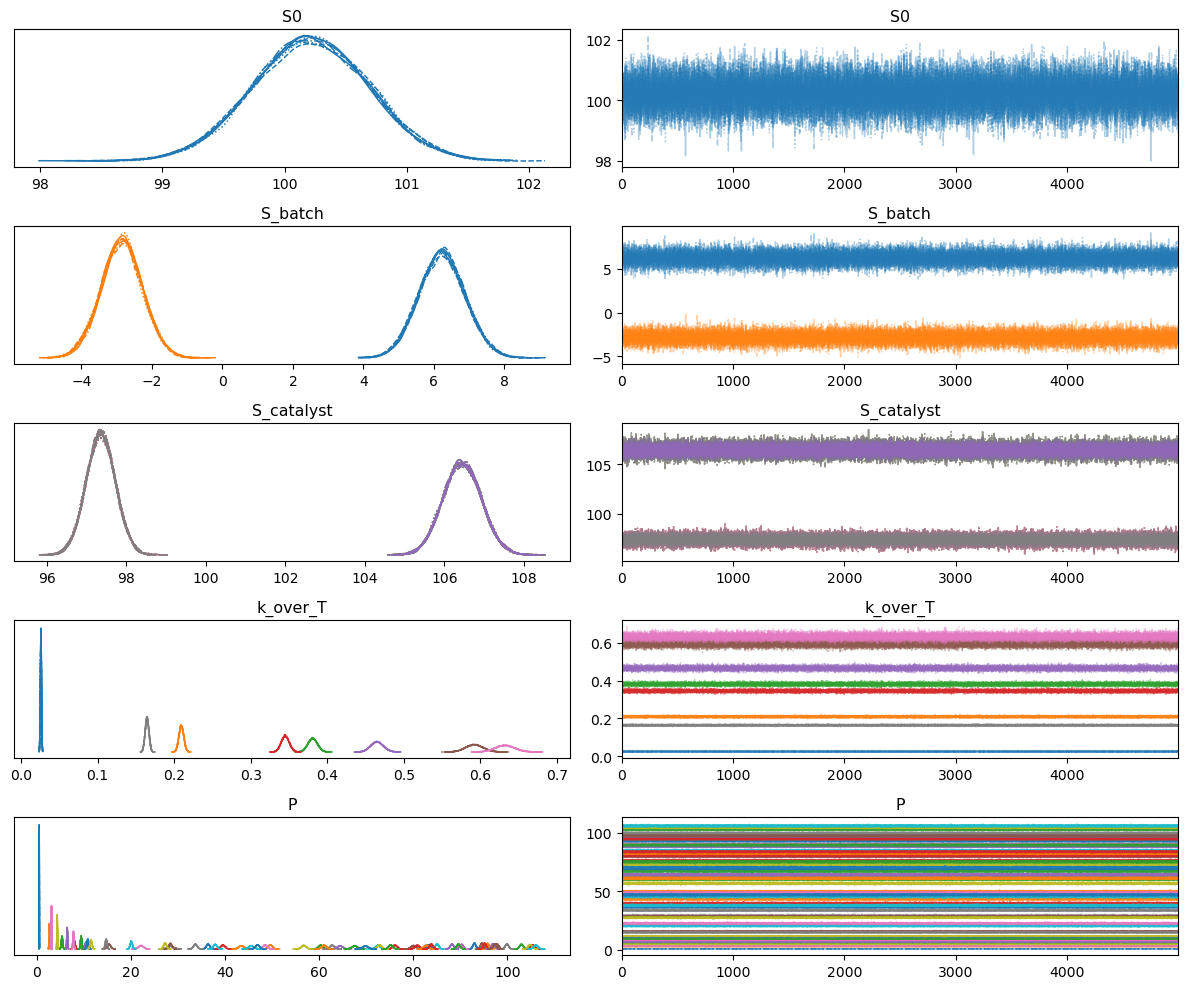

In [26]:
pm.plot_trace(
    trace3,
    var_names=[
        "S0", 
        "S_batch",
        "S_catalyst",
        "k_over_T",
        "P",
    ]
)
plt.tight_layout()

In [27]:
with pmodel3:
    # add the GP conditional to the model, given the new X values
    f_pred3 = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace3.extend(pm.sample_posterior_predictive(trace3, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

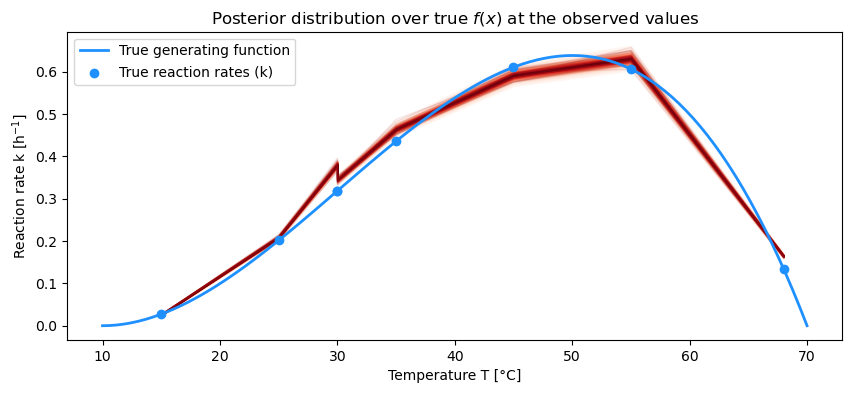

In [28]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
f_post3 = az.extract(trace3, var_names="k_over_T").transpose("sample", ...)
plot_gp_dist(ax, f_post3, T_sampled[:, None])


# plot the data and the true latent function
# ax.plot(, f_true, "dodgerblue", lw=3, label="True generating function "f"")
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)
plt.scatter(T_sampled, true_rates, color="dodgerblue", label="True reaction rates (k)", zorder=3)


# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

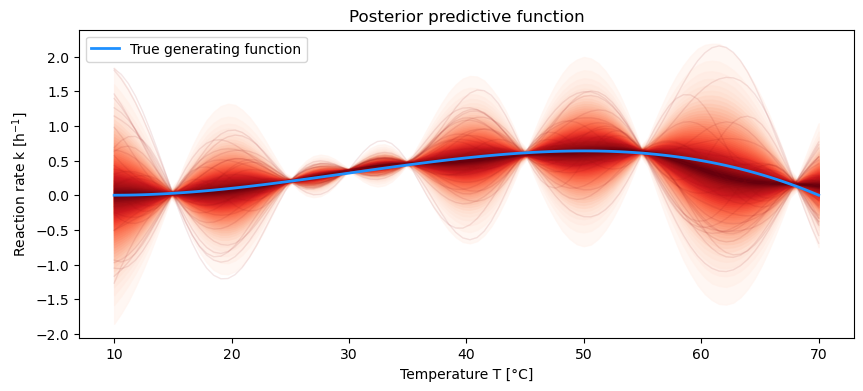

In [29]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred3 = az.extract(trace3.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred3, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();

## Compare to SOTA: Fit reaction rate via regression and use a GP

In [31]:
observed_bias

array([[  5.92241418,   0.        ,   6.31021269,  10.38973017,
         18.38493058,  12.69413931,  17.24532395,  29.98885042],
       [  3.8706728 ,  20.34320532,  40.89154039,  38.37629045,
         63.95347847,  80.28962243,  90.26211294,  96.40947938],
       [  0.        ,  41.55608364,  57.32911508,  80.98694948,
         81.34337462,  80.67486892,  98.4457822 , 114.7183389 ],
       [  0.        ,  23.50759259,  52.03951647,  64.37011979,
         72.54735421,  74.03049579, 105.53384678, 102.15196113],
       [  8.35251476,  44.0031286 ,  67.74537984,  73.35743621,
         88.29813412,  99.54372808, 110.99006309, 106.67042029],
       [  6.30073611,  43.67750627,  73.86490851,  77.39782681,
         85.02569214,  94.27101651,  94.20327564,  93.80605498],
       [ 12.4684604 ,  50.19445048,  69.39869206,  79.16747074,
         87.70461855,  93.44888105,  98.8824251 ,  98.23874767],
       [  0.        ,   9.15434067,  27.33835524,  30.81314356,
         53.34485103,  64.6822506

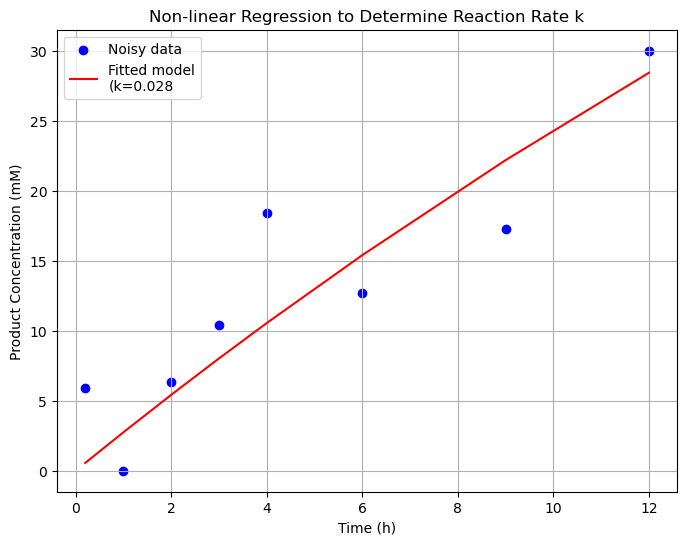

Estimated parameters:
k (reaction rate): 0.028 1/h


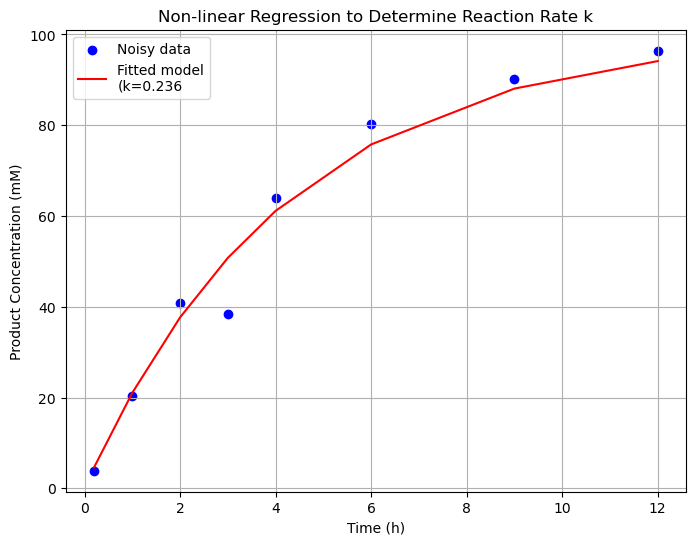

Estimated parameters:
k (reaction rate): 0.236 1/h


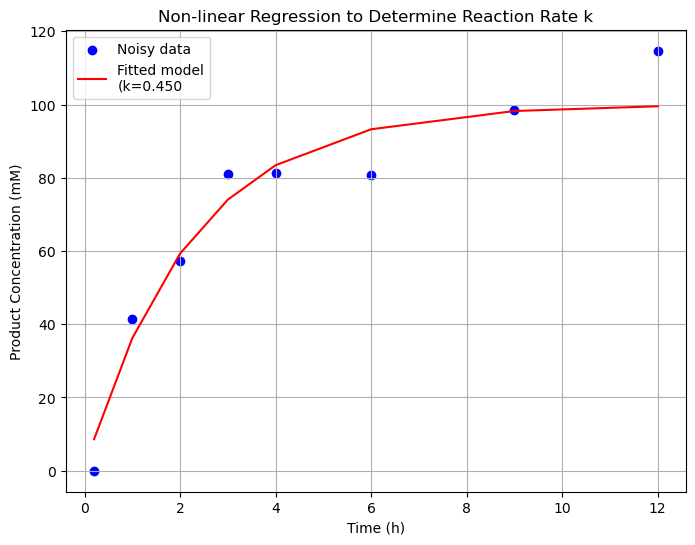

Estimated parameters:
k (reaction rate): 0.450 1/h


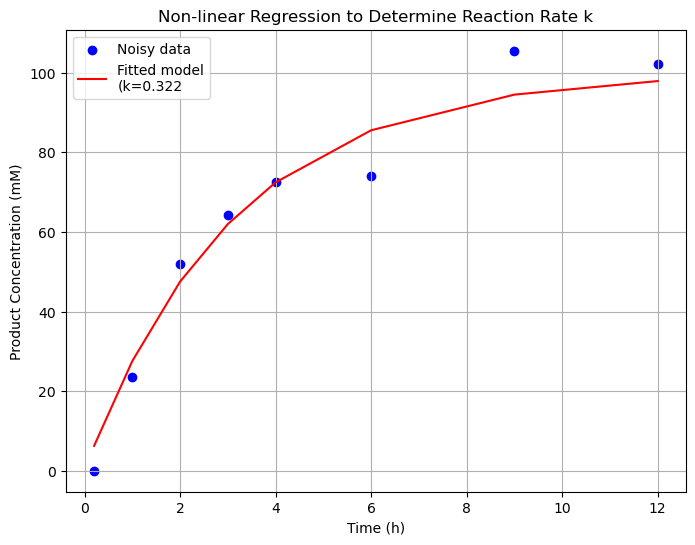

Estimated parameters:
k (reaction rate): 0.322 1/h


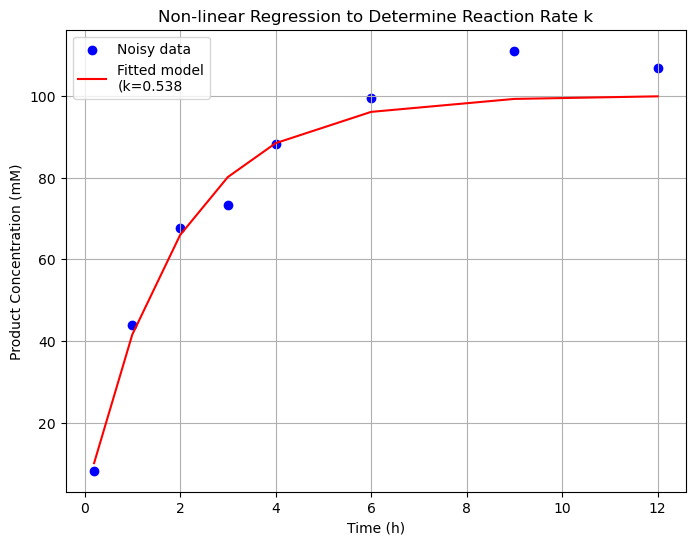

Estimated parameters:
k (reaction rate): 0.538 1/h


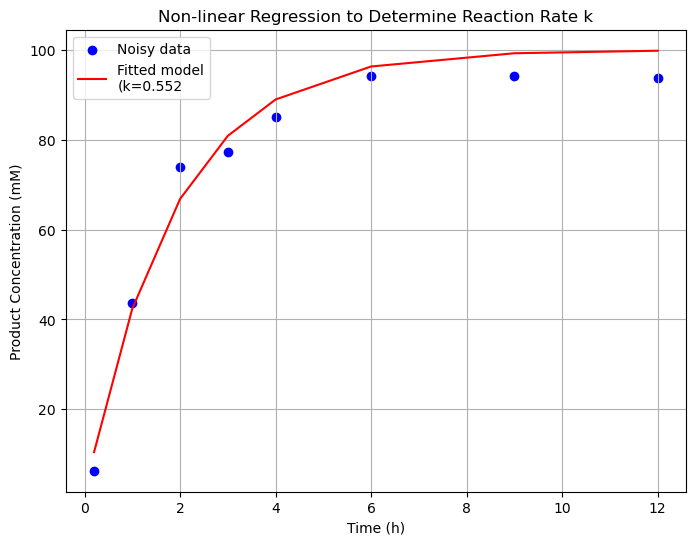

Estimated parameters:
k (reaction rate): 0.552 1/h


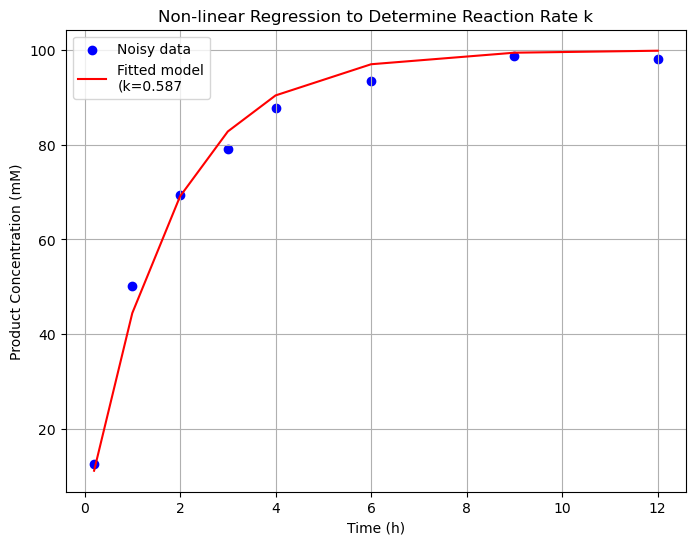

Estimated parameters:
k (reaction rate): 0.587 1/h


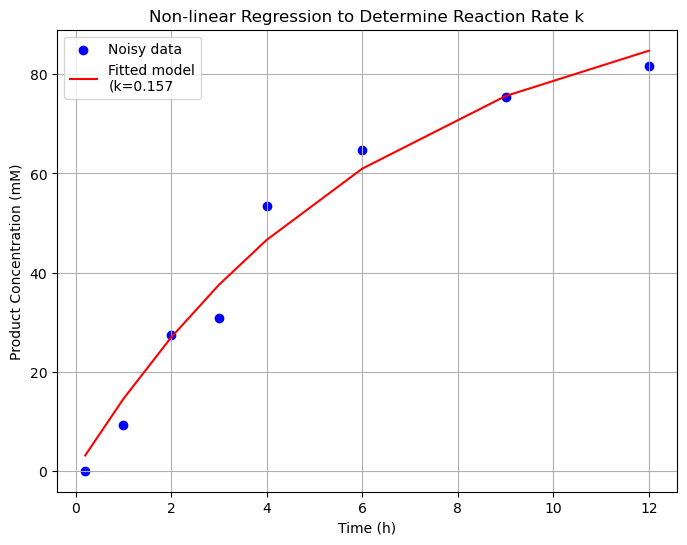

Estimated parameters:
k (reaction rate): 0.157 1/h


In [32]:
from scipy.optimize import curve_fit

# Function defining the mass-action model
def mass_action_model(t, k):
    return 100 * (1 - np.exp(-k * t))

k_estimated = []
for i in range(observed_bias.shape[0]):
    P_samples = observed_bias[i, :]
    # Perform non-linear regression
    initial_guess = [0.1]  # Initial guess for k
    popt, pcov = curve_fit(mass_action_model, time, P_samples, p0=initial_guess)

    # Extract optimized parameters
    k_fit = popt[0]

    k_estimated.append(k_fit)

    # Generate fitted curve
    P_fitted = mass_action_model(time, k_fit)

    # Plot results
    plt.figure(figsize=(8, 6))
    plt.scatter(time, P_samples, label="Noisy data", color="blue")
    plt.plot(time, P_fitted, label=f"Fitted model\n(k={k_fit:.3f}", color="red")
    plt.xlabel("Time (h)")
    plt.ylabel("Product Concentration (mM)")
    plt.title("Non-linear Regression to Determine Reaction Rate k")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Estimated parameters:")
    print(f"k (reaction rate): {k_fit:.3f} 1/h")


In [33]:
coords = {
    "catalyst": np.arange(8),
}

with pm.Model(coords=coords) as pmodel4:
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst",
    )
    k_data = pm.Data(
        "k_estimated",
        value=k_estimated,
        dims="catalyst",
    )
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfNormal("sigma", sigma=2)
    gp.marginal_likelihood(
        "likelihood",
        X=temp_data[:, None],
        y=k_data,
        sigma=sigma,
    )
    trace4 = pm.sample(5000, tune=5000, chains=8, cores=-1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [sigma]


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Sampling 8 chains for 5_000 tune and 5_000 draw iterations (40_000 + 40_000 draws total) took 54 seconds.
There were 610 divergences after tuning. Increase `target_accept` or reparameterize.


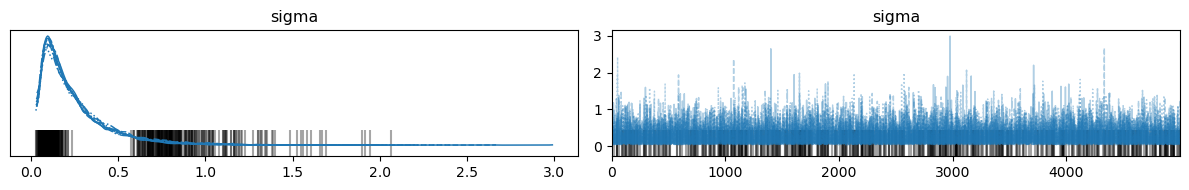

In [34]:
pm.plot_trace(trace4)
plt.tight_layout()

In [35]:
with pmodel4:
    # add the GP conditional to the model, given the new X values
    f_pred4 = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace4.extend(pm.sample_posterior_predictive(trace4, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

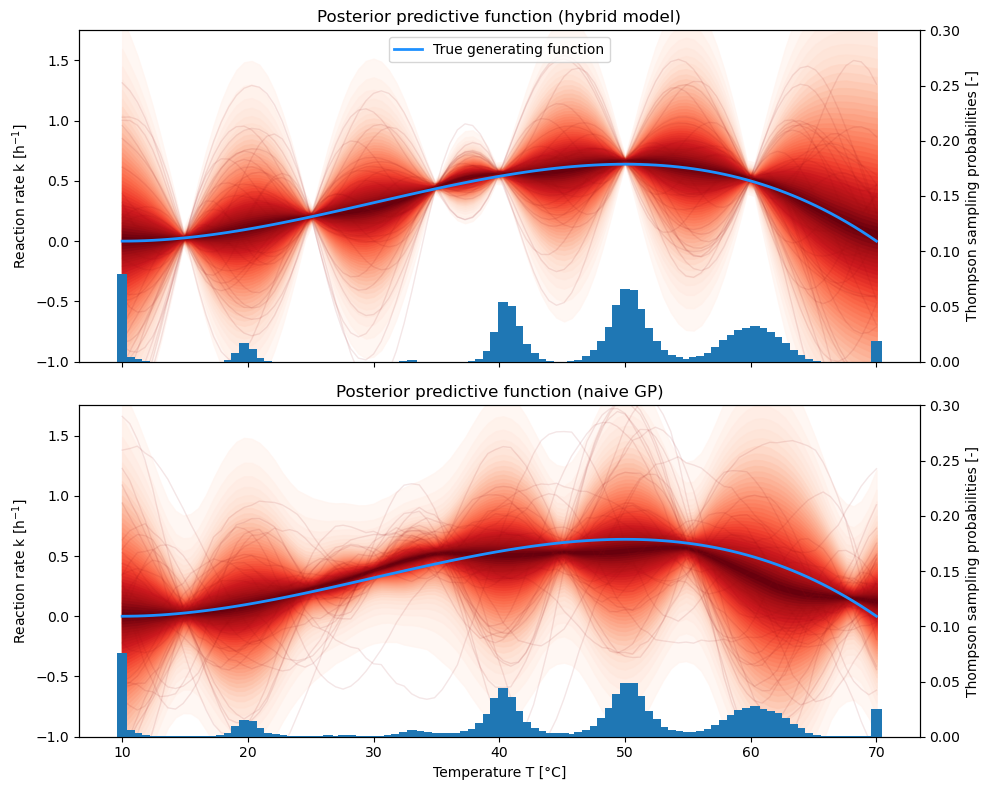

In [36]:
import pyrff

fig, axs = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)

ax = axs[0]
f_pred3 = az.extract(trace3.posterior_predictive, var_names="f_pred").transpose("sample", ...)

probs = pyrff.sampling_probabilities(trace3.posterior_predictive["f_pred"].stack(sample=("chain", "draw")), correlated=True)
ax2 = ax.twinx()
ax2.bar(T_full, probs)
ax2.set_ylim(0, 0.3)
ax2.set_ylabel("Thompson sampling probabilities [-]")
plot_gp_dist(ax, f_pred, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (hybrid model)")
ax.legend(loc="upper center")
ax.set_ylim(-1, 1.75)

ax = axs[1]
f_pred4 = az.extract(trace4.posterior_predictive, var_names="f_pred").transpose("sample", ...)
probs = pyrff.sampling_probabilities(trace4.posterior_predictive["f_pred"].stack(sample=("chain", "draw")), correlated=True)
ax2 = ax.twinx()
ax2.bar(T_full, probs)
ax2.set_ylim(0, 0.3)
ax2.set_ylabel("Thompson sampling probabilities [-]")
plot_gp_dist(ax, f_pred4, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (naive GP)")
ax.set_ylim(-1, 1.75)

plt.tight_layout()
plt.show()